# Packages

In [1]:
import ee
import geemap

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Open Nighttime Lights'

Most satellite data you’ll work with is stored as a raster file (e.g. GeoTiff), including the nighttime lights data we’ve been working with. Vector files are also common with geospatial data, particularly for representing the polygons and points that represent places on earth, like specific locations (points) or entire countries (polygons).

When analyzing remotely sensed data, you’re often using both types of files so it’s important to get comfortable with both. Clipping a raster image to a particular vector file boundary is a common operation. In this tutorial we’ll work with raster and vector formats to calculate zonal statistics, particularly a common metric for nighttime lights called the Sum Of Lights (SOL). 

While visualing satellite data is interesting and can help guide inquiry, analysts must often draw some inferences from the data.

A common way to do this is to summarize your raster file data, which is represented a pixel-values, by aggregating, or “reducing” your information to a zonal statistic, such as the mean, median, minimum value, maximum value, sum, etc. When you’re working with socioeconomic or geopolitic analysis, these “zones” will often be administrative boundaries, such as for a country, province, or urban agglomeration, stored as vector files.

These summarized data can be used for further visualization (such as with a choropleth) or for statistical analysis, including time series analysis or cross-sectional analysis. Or perhaps in regression or classification to infer some other charasterics or even predictions related to your data.

SOL is a reduction of nighttime lights data, done by summing the total radiance per pixel (DN values for DMSP-OLS data or radiance in Watts/cm2/sr for VIIRS-DNB data) for a given time period (e.g. month) for a given geospatial boundary (e.g. country).

# Import Data

We’re looking at VIIRS-DNB data for the month of January 2015. We’ll use the stray-light corrected monthly composites, the `avg_rad` band.

In [2]:
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').filterDate('2015-01-01', '2015-01-31').select('avg_rad')
viirs

**Pay attention to data type!** Note our variable viirs contains only 1 image, but it is still in the structure of ImageCollection. Later, we’ll use methods for `ee.Image`, so we’ll need this in an Image structure.

That can be done either by using the `ee.Image` constructor or just selecting the “first” image, which will of course be the only image.

In [3]:
viirsJan2015 = ee.Image(viirs)

# or equivalently

viirsJan2015 = viirs.first()
viirsJan2015

Next, we'll extract shapefiles for geopolitical boundaries from datasets stored in Google Earth Engine.

In [4]:
japan0 = ee.Feature(ee.FeatureCollection('FAO/GAUL/2015/level0')\
        .filter(ee.Filter.eq('ADM0_NAME', 'Japan'))\
        .first()).geometry()
japan0

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Collection.first",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.filter",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.loadTable",
                      "arguments": {
                        "tableId": {
                          "constantValue": "FAO/GAUL/2015/level0"
                        }
                      }
                    }
                  },
                  "filter": {
                    "functionInvocationValue": {
                      "functionName": "Filter.equals",
                      "arguments": {
                        "leftField": {
                          "constantValue": "ADM0_NAME"
                        },
                        "rightValue": {
                          "constantValue": "Japan"
                        }
                      }
                    }
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [5]:
# Get prefectural entities
japan1 = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM0_NAME', 'Japan'))
print(f"There are {japan1.size().getInfo()} level one admin units in Japan.")

There are 47 level one admin units in Japan.


# Calculate SOL for Japan in January 2015

We will use the `reduceRegion()` function of an Image to get the sum of nighttime lights, a function you’ll remember from Cell statistics and basic band math (10 min). To get the SOL for Japan in 2015, we use the `reduceRegion` method on our Japan geometry. The resulting value is our SOL. Recall that we pass our chosen `Reducer` function, `.sum()` in this case.

Since our image (`viirsJan2015`) covers the entire globe, we’ll constrain scope by passing a geometry. We’ll use the vector files we just imported. These files have a method called `.geometry()` that extracts the vector data for the shape itself.

We also will use the `scale` parameter set to 500 meters. This is used by `reduceRegion` to identify what data (pixels in the raster) to include in its statistic (`sum()` in our case). We wont get into the details on the affine transformations and CRS projects that factor in here (for more, read the GEE documentation here).

You can also read more there about “weighted” reducers, such as `ee.Reducer.mean()` or `.sum()`.

What is helpful here, is to recall that data in raster files are represented by cells or pixels (think grid or array). Wheras data in vector files represent formulas for calculating lines and points.

So think of each pixel in the raster file as covering an area and the value (nightime radiance) represents the entire area. A weighted reducer, such as `Reducer.mean()` or `.Reducer.sum()` will calculate the portio of the pixel value based on the area of overlap (e.g. if 50% of the pixel is inside the boundary, then the value of the pixel will be scaled by 50%, etc). If a pixel is masked for data quality (like cloud coverage) or has less than 0.5% of its area inside the polygon, it will not be included.

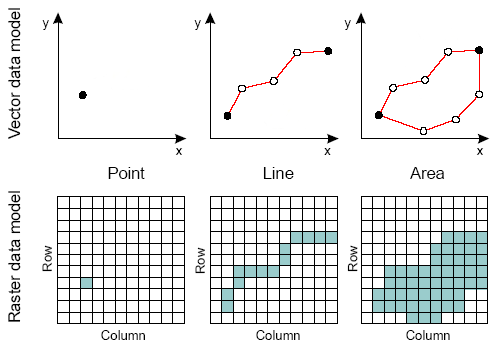

Our final argument for `ee.reduceRegion()` will be the maxPixels parameter, which has a threshold to prevent large computations. For most scales (including 500m), you’ll have to reset that value to something much larger, like 1 billion.

Let’s calculate the “Sum of Lights” at a scale of 500 m. This is not completely arbitrary, since our VIIRS-DNB data is roughly 500m in resolution (at the equator).

In [6]:
scaleFactor = 500

japanSOL500 = viirsJan2015.reduceRegion(reducer = ee.Reducer.sum(),
                                        geometry = japan0,
                                        scale = scaleFactor,
                                        maxPixels = 1e9)
print(f"The SOL for Japan at {scaleFactor}m scale is: {japanSOL500.get('avg_rad').getInfo():.2f}")

The SOL for Japan at 500m scale is: 3428588.93


In [7]:
# Smaller scale
scaleFactor = 100

japanSOL100 = viirsJan2015.reduceRegion(reducer = ee.Reducer.sum(),
                                        geometry = japan0,
                                        scale = scaleFactor,
                                        maxPixels = 1e9)
print(f"The SOL for Japan at {scaleFactor}m scale is: {japanSOL100.get('avg_rad').getInfo():.2f}")

The SOL for Japan at 100m scale is: 85731260.26


Hm..this is a very different value. It’s not just slightly different…it’s off by an order of magnitude. It’s as if we’re measuring two different countries.

The boundaries of complex (even simple) polygons can be accurately captured by vectors (that’s one reason they’ve useful for representing and scaling shapes), but mapping to pixels means “dumbing down” the representation to something like “is this pixel “in” or “out” or “how much of this pixel is “in”…and that may depend greatly on the pixel size!

This will be particularly true if you have a highly complex polygon like the boundary of a country. Think fractals!

Fractal geometry is obviously out of scope for us here, but this is a critical learning moment. If you are working with data, you must understand the data and how you are manipulating it. If not, and if you just mindlessly plug data into scripts and formulae, you can wreak havoc with decision-making stakeholders. Consider if you were reporting SOL for Japan or doing further analysis with it. Which is the correct value for SOL in January 2015?:
- 3,428,588
- 85,731,260

The scale by which you include pixels and calculate them has a profound impact.

Using raw SOL (without standardizing or normalizing data) can be problematic for this reason. And others: VIIRS data are much more sensitive that DMSP-OLS, which is a good thing, but it is more susceptible to noise, particularly in low-light areas where small fluctuations are noticeable. Onboard calibration does keep the observations somewhat stable, but it’s not perfect. These fluctuations are usually too small to be an issue, but if you were to sum up radiance over large areas, like that of a midsize province (to say nothing of a large one or a country), this variance adds up…literally geometrically.

Some options are:
1. Use another metric, like avg radiance per pixel per period, or standardize SOL by getting the SOL per period per square meter
2. If you have to use SOL, be careful when doing any comparison across regions of varying size. If you are comparing a single region with itself (i.e. a timeseries) then SOL might be just fine.
3. At the very least, be absolutely clear in your documentation what your choice of scale is and the implications on your results or analysis.

This is a larger issue with big data given the many ways to interpret signal…so please be responsible and state your assumptions and decisions clearly!

If we were to go back and get our SOL calculation for Japan, but instead get the per-pixel avg instead of the raw sum, you’ll see that the scale is much less influential.

In [9]:
scaleFactor = 500

japanSOL = viirsJan2015.reduceRegion(reducer = ee.Reducer.mean(),
                                     geometry = japan0,
                                     scale = scaleFactor,
                                     maxPixels = 1e9)

print(f"The avg radiance for Japan in Jan 2015 (per {scaleFactor}m grid) is: {japanSOL.get('avg_rad').getInfo():.4f}")

The avg radiance for Japan in Jan 2015 (per 500m grid) is: 1.8117


In [10]:
scaleFactor = 100

japanSol = viirsJan2015.reduceRegion(reducer = ee.Reducer.mean(),
                                     geometry = japan0,
                                     scale = scaleFactor,
                                     maxPixels = 1e9)

print(f"The avg radiance for Japan in Jan 2015 (per {scaleFactor}m grid) is: {japanSOL.get('avg_rad').getInfo():.4f}")

The avg radiance for Japan in Jan 2015 (per 100m grid) is: 1.8117


# Average radiance by Japanese prefecture for January 2015

We calculated the SOL (and the avg radiance per pixel) for the entire country using one vector file. It is often the case that you’ll calculate zonal statistics for all the areas in a given administration level.

Let’s calculate the avg radiance at the 100meter scale for all the prefecture entities in Japan for January 2015.

GEE makes this quite simple to do for a series of geometries. For a single geometry (the boundary of Japan), we used `reduceRegion()`.

For a collection of geometries, we’ll use `reduceRegions()` (with a few subtle changes, for example passing the collection instead of a single geometry).

In [11]:
scaleFactor = 100

japan_pref = ee.FeatureCollection(viirsJan2015.reduceRegions(reducer = ee.Reducer.mean(),
                                                             collection = japan1,
                                                             scale = scaleFactor))

# Get the descriptive statistics of our average radiance (the "mean" field)
japan_pref.aggregate_stats('mean').getInfo()

{'max': 19.182646318291887,
 'mean': 2.6677388741324433,
 'min': 0.3483685456093894,
 'sample_sd': 3.903264078647388,
 'sample_var': 15.23547046765904,
 'sum': 125.38372708422483,
 'sum_sq': 1035.3226844385154,
 'total_count': 47,
 'total_sd': 3.8615167384770763,
 'total_var': 14.911311521538636,
 'valid_count': 47,
 'weight_sum': 47,
 'weighted_sum': 125.38372708422483}

There’s a lot you can do with this data. We’ll plot some histograms and time series in a later tutorial. You can also export this as table data for further analysis or fusion with other data sources (i.e. statistics at the prefecture level).

You can also visualize these data quickly with a choropleth. To do that, use the `reduceToImage()` function to convert this structured data back to a raster file (it will assign the appropriate value for each geometry to each underlying pixel within the geometry).

In [12]:
radiance_img = japan_pref.reduceToImage(properties = ['mean'], reducer = ee.Reducer.first())
radiance_img

A choropleth is a map that uses different shades or colors to indicate various quantities for given areas. Using our color palette we can do this for the avg radiance (per pixel) of each prefecture in Japan for January 2015. We’ll set the min/max values based on the aggregated stats above (min=1, max=17)

We’ll also add our feature collection, `japan_pref` as a layer so that the prefecture boundares are mapped.

In [13]:
japanMap = geemap.Map()

japanMap.centerObject(japan1, zoom = 5)
viz_params = {
    'min': 1,
    'max': 17,
    'palette': ['2C105C','711F81','B63679','EE605E','FDAE78','FCFDBF']
}

japanMap.addLayer(japan_pref, {}, 'Prefecture boundaries', opacity = 0.5)
japanMap.addLayer(radiance_img, viz_params, 'VIIRS Jan 2015 avg rad by prefecture', opacity = 0.6)
japanMap.addLayerControl()
japanMap

Map(center=[37.408423540205185, 137.58817577632914], controls=(WidgetControl(options=['position', 'transparent…

You can see the prefecture entites of Tokyo and Osake are quite bright, followed by other metro areas, relative to the rest of the country.

Let’s add the actual VIIRS-DNB layer to see the observed lights for January 2015. We’ll set the same min/max.

In [14]:
japanMap2 = geemap.Map()

japanMap2.centerObject(japan1, zoom = 5)
japanMap2.addLayer(japan_pref, {}, 'Prefecture boundaries', opacity = 0.5)
japanMap2.addLayer(radiance_img, viz_params, 'VIIRS Jan 2015, avg rad by prefecture', opacity = 0.6)
japanMap2.addLayer(viirsJan2015, {'min': 1, 'max': 17}, 'VIIRS-DNB Jan 2015', opacity = 0.6)
japanMap2.addLayerControl()
japanMap2

Map(center=[37.408423540205185, 137.58817577632914], controls=(WidgetControl(options=['position', 'transparent…

You can see where the patterns of nighttime lights align with our zonal statistics (avg radiance) as represented by the choropleth.